# Modelling

In [40]:
import pandas as pd
import numpy as np
import re
import time
import os

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import Perceptron, LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, HistGradientBoostingClassifier

from sklearn.neural_network import MLPClassifier

from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

rng = np.random.RandomState(42)

# from keras import Sequential
# from keras.layers import Dense

import warnings
warnings.filterwarnings('ignore') # hide warnings to avoid cluttering the notebook output

In [41]:
class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None
        self._elapsed_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._elapsed_time = None
        self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        self._elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Elapsed time: {int(divmod(self._elapsed_time, 60)[0])} minutes, {int(divmod(self._elapsed_time, 60)[1])} seconds")

    def duration(self):
        """Return the elapsed time from the timer."""
        if self._elapsed_time is None:
            raise TimerError(f"Timer has not run. Use .start() and .stop() to start and stop the timer.")

        return self._elapsed_time

In [42]:
df = pd.read_csv('../assets/df_merge_final.csv', parse_dates=['Date', 'Sunrise_1', 'Sunset_1'])

In [43]:
def create_dt_features(dataframe):
    # create datetime related features
    dataframe['daylight_duration'] = pd.to_timedelta(dataframe['daylight_duration'])
    dataframe['Daylight_hours'] = round(dataframe['daylight_duration'].dt.total_seconds() / (60*60), 2)
    dataframe['Sunrise'] = round(pd.to_timedelta(dataframe['Sunrise_1'].dt.time.astype(str)).dt.total_seconds()/3600, 2)
    dataframe['Sunset'] = round(pd.to_timedelta(dataframe['Sunset_1'].dt.time.astype(str)).dt.total_seconds()/3600, 2)
    # create date related features
    # dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe['Month'] = dataframe['Date'].dt.month
    dataframe['Day'] = dataframe['Date'].dt.day
    # round off Latitude, Longitude for more general locations
    dataframe['Latitude'] = round(dataframe['Latitude'], 3)
    dataframe['Longitude'] = round(dataframe['Longitude'], 3)
    return dataframe

In [44]:
df = create_dt_features(df)

In [45]:
df.head()

,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Station,Tavg,...,AvgSpeed,Sunrise_1,Sunset_1,daylight_duration,Humidity,Daylight_hours,Sunrise,Sunset,Month,Day
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.955,-87.801,9,1,0,1.0,74.0,...,6.5,1900-01-01 04:21:00,1900-01-01 19:17:00,0 days 14:56:00,57.4,14.93,4.35,19.28,5,29
1,2007-05-29,CULEX RESTUANS,T002,41.955,-87.801,9,1,0,1.0,74.0,...,6.5,1900-01-01 04:21:00,1900-01-01 19:17:00,0 days 14:56:00,57.4,14.93,4.35,19.28,5,29
2,2007-05-29,CULEX RESTUANS,T007,41.995,-87.769,9,1,0,1.0,74.0,...,6.5,1900-01-01 04:21:00,1900-01-01 19:17:00,0 days 14:56:00,57.4,14.93,4.35,19.28,5,29
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974,-87.825,8,1,0,1.0,74.0,...,6.5,1900-01-01 04:21:00,1900-01-01 19:17:00,0 days 14:56:00,57.4,14.93,4.35,19.28,5,29
4,2007-05-29,CULEX RESTUANS,T015,41.974,-87.825,8,4,0,1.0,74.0,...,6.5,1900-01-01 04:21:00,1900-01-01 19:17:00,0 days 14:56:00,57.4,14.93,4.35,19.28,5,29


In [46]:
# specify features
num_features = ['Latitude', 'Longitude', 'AddressAccuracy', 'Tavg', 'Depart', 'Heat', 'PrecipTotal', 'SeaLevel', 'ResultDir', 'AvgSpeed', 'Humidity', 'Daylight_hours', 'Month', 'Day', 'Sunrise', 'Sunset']
cat_features = ['Species', 'Trap']
text_features = ['CodeSum']

features = num_features + cat_features + text_features

# define metric to optimise during GridSearch
score_metric = ['f1', 'roc_auc']

In [47]:
X = df[features]
y = df['WnvPresent']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=rng, stratify=y)

In [49]:
# Processing steps before modelling (standardisation, one hot encoding, over/under-sampling)
minmax = MinMaxScaler(feature_range=(0, 1))
ohe = OneHotEncoder(drop='if_binary', handle_unknown='ignore')
count = CountVectorizer()

sample_smotetomek = SMOTETomek(random_state=rng, n_jobs=2)

text_pipe = Pipeline([
    ("squeeze", FunctionTransformer(lambda x: x.squeeze())),
    ('vector', count),
    ('array', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('scale', minmax)
])

col_transform = ColumnTransformer([
    ('MinMaxScaler', minmax, num_features),
    ('OneHotEncoder', ohe, cat_features),
    ('CountVectorizer', text_pipe, text_features)
], remainder='drop',
sparse_threshold=0
)

In [50]:
# WORKING FILE
# perceptron = Perceptron(random_state=42)

# model = Sequential()
# model.add(Dense(50, input_dim=53, activation='relu')) # input
# model.add(Dense(100, activation='relu')) # hidden
# model.add(Dense(50, activation='relu'))  # hidden
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['binary_crossentropy']) 


In [51]:
# Instantiating models for classification
lr = LogisticRegression(random_state=rng)
knn = KNeighborsClassifier()
pct = Perceptron(random_state=rng)
mlp = MLPClassifier(hidden_layer_sizes=(8,6,1), max_iter=300, activation='tanh', solver='adam', random_state=rng)
rf = RandomForestClassifier(random_state=rng)
ada = AdaBoostClassifier(random_state=rng)
gbc = GradientBoostingClassifier(random_state=rng)
hgbc = HistGradientBoostingClassifier(random_state=rng)

In [52]:
# create dict to store model performance results for comparison
model_dict = {
    'model_list': [],
    'mean_train_f1_score': [],
    'mean_test_f1_score': [],
    'mean_train_roc_auc_score': [],
    'mean_test_roc_auc_score': [],
    'best_params': [],
    'runtime': []
}

In [53]:
# run pipe, fit params and return best estimator
def run_pipe(clf: object, pipe_params: dict):
    t = Timer()
    model_name = re.match(r'^(\w+)(?=\()', str(clf)).group()
    print(f"Fitting {model_name}")

    # create pipe
    pipe = Pipeline([
        ('transform', col_transform),
        ('sample', sample_smotetomek),
        ('clf', clf)
    ])
    
    
    # create GridSearchCV
    grid = GridSearchCV(
        estimator = pipe,
        param_grid = pipe_params,
        scoring = score_metric,
        n_jobs = -3,
        cv = 3,
        verbose = 1,
        error_score='raise',
        refit='f1'
    )

    t.start()
    grid.fit(X_train, y_train)
    t.stop()
    
    # test_score = cross_val_score(grid.best_estimator_, X_test, y_test, scoring=score_metric, cv=3, n_jobs=-3)
    train_score = cross_validate(grid.best_estimator_, X_train, y_train, scoring=score_metric, cv=3, n_jobs=-3)
    test_score = cross_validate(grid.best_estimator_, X_test, y_test, scoring=score_metric, cv=3, n_jobs=-3)
    # store average scores
    model_dict['model_list'].append(model_name)
    model_dict['mean_train_f1_score'].append(train_score['test_f1'].mean())
    model_dict['mean_train_roc_auc_score'].append(train_score['test_roc_auc'].mean())
    model_dict['mean_test_f1_score'].append(test_score['test_f1'].mean())
    model_dict['mean_test_roc_auc_score'].append(test_score['test_roc_auc'].mean())
    # model_dict['mean_test_score'].append(test_score.mean())
    model_dict['best_params'].append(grid.best_params_)
    model_dict['runtime'].append(t.duration())

    print("Best Score: ", grid.best_score_)
    print("Best Params: ", grid.best_params_)
    print()
    return grid.best_estimator_, grid.cv_results_

In [54]:
# create table with model performance results
def table_model_results():
    model_performance = pd.DataFrame(model_dict)
    
    model_performance.insert(
        loc = 3,
        column = 'f1_score_delta',
        value = abs(model_performance['mean_train_f1_score'] - model_performance['mean_test_f1_score'])
        )

    model_performance.insert(
        loc = 6,
        column = 'roc_auc_score_delta',
        value = abs(model_performance['mean_train_roc_auc_score'] - model_performance['mean_test_roc_auc_score'])
        )

    return model_performance.sort_values(by="mean_train_f1_score", ascending=False).round(
        {'mean_train_f1_score': 4,
        'mean_train_roc_auc_score': 4,
        'mean_test_f1_score':4,
        'mean_test_roc_auc_score': 4,
        'f1_score_delta':4,
        'roc_auc_score_delta':4,
        'runtime': 2}
        )

In [55]:
lr_params = {
    'clf__solver': ['liblinear', 'newton-cg', 'lbfgs'],
    'clf__penalty': ['l2'],
    'clf__C': [100, 10, 1.0, 0.1, 0.01],
    'clf__max_iter': [100, 150, 500]
}

knn_params = {
    'clf__n_neighbors': [3, 5, 9, 15],
    'clf__weights': ['uniform', 'distance']
}

pct_params = {
    'clf__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'clf__class_weight': [None, 'balanced']
}

mlp_params = {
    
}

rf_params = {
    'clf__ccp_alpha': [0.0, 0.01, 0.1],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__n_estimators': [500, 700, 900]
}

ada_params = {
    'clf__learning_rate': [1.0, 2.0, 10],
    'clf__n_estimators': [150, 200, 250]
}

gbc_params = {
    'clf__learning_rate': [0.001, 0.01, 0.1],
    'clf__subsample': [0.5, 0.7, 1.0],
    'clf__max_depth': [3, 7, 9],
    'clf__n_estimators': [350]
}

hgbc_params = {
    'clf__learning_rate': [0.001, 0.01, 0.1],
    'clf__l2_regularization': [0, 0.1, 1],
    'clf__max_iter': [100, 200, 300]
}

In [56]:
lr_best, lr_results = run_pipe(lr, lr_params)

Fitting LogisticRegression
Fitting 3 folds for each of 45 candidates, totalling 135 fits
Elapsed time: 0 minutes, 38 seconds
Best Score:  0.23033029725375387
Best Params:  {'clf__C': 100, 'clf__max_iter': 100, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}



In [57]:
knn_best, knn_results = run_pipe(knn, knn_params)

Fitting KNeighborsClassifier
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Elapsed time: 0 minutes, 6 seconds
Best Score:  0.18755368042454798
Best Params:  {'clf__n_neighbors': 3, 'clf__weights': 'distance'}



In [58]:
pct_best, pct_results = run_pipe(pct, pct_params)

Fitting Perceptron
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Elapsed time: 0 minutes, 5 seconds
Best Score:  0.17196362795409578
Best Params:  {'clf__class_weight': None, 'clf__penalty': 'l2'}



In [59]:
mlp_best, mlp_results = run_pipe(mlp, mlp_params)

Fitting MLPClassifier
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Elapsed time: 0 minutes, 23 seconds
Best Score:  0.21944958759600808
Best Params:  {}



In [60]:
rf_best, rf_results = run_pipe(rf, rf_params)

Fitting RandomForestClassifier
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Elapsed time: 1 minutes, 29 seconds
Best Score:  0.22306208488248594
Best Params:  {'clf__ccp_alpha': 0.01, 'clf__max_features': 'log2', 'clf__n_estimators': 500}



In [61]:
ada_best, ada_results = run_pipe(ada, ada_params)

Fitting AdaBoostClassifier
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Elapsed time: 0 minutes, 36 seconds
Best Score:  0.25899874269648276
Best Params:  {'clf__learning_rate': 1.0, 'clf__n_estimators': 150}



In [62]:
# gbc_best, gbc_results = run_pipe(gbc, gbc_params)

In [63]:
hgbc_best, hgbc_results = run_pipe(hgbc, hgbc_params)

Fitting HistGradientBoostingClassifier
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Elapsed time: 2 minutes, 0 seconds
Best Score:  0.281890783509605
Best Params:  {'clf__l2_regularization': 0.1, 'clf__learning_rate': 0.01, 'clf__max_iter': 300}



In [64]:
model_performance = table_model_results()
model_performance

,model_list,mean_train_f1_score,mean_test_f1_score,f1_score_delta,mean_train_roc_auc_score,mean_test_roc_auc_score,roc_auc_score_delta,best_params,runtime
6,HistGradientBoostingClassifier,0.2758,0.2770,0.0012,0.8089,0.7986,0.0102,"{'clf__l2_regularization': 0.1, 'clf__learning...",120.22
5,AdaBoostClassifier,0.2710,0.2320,0.0389,0.8080,0.7754,0.0326,"{'clf__learning_rate': 1.0, 'clf__n_estimators...",36.88
0,LogisticRegression,0.2249,0.1984,0.0265,0.7516,0.7360,0.0156,"{'clf__C': 100, 'clf__max_iter': 100, 'clf__pe...",38.80
4,RandomForestClassifier,0.2137,0.1971,0.0166,0.7954,0.7794,0.0159,"{'clf__ccp_alpha': 0.01, 'clf__max_features': ...",89.34
3,MLPClassifier,0.2103,0.1956,0.0147,0.7245,0.6874,0.0370,{},23.55
2,Perceptron,0.1977,0.1367,0.0610,0.7332,0.7085,0.0247,"{'clf__class_weight': None, 'clf__penalty': 'l2'}",5.04
1,KNeighborsClassifier,0.1862,0.1643,0.0218,0.6707,0.6386,0.0321,"{'clf__n_neighbors': 3, 'clf__weights': 'dista...",6.81


In [65]:
# check coefficents from LogisticRegression
# feature_names = lr_best[0].get_feature_names_out()
# coefficients = lr_best[2].coef_
# features_coefs = pd.DataFrame([feature_names, coefficients.reshape(52,)]).transpose()
# features_coefs.rename(columns={0: 'feature', 1: 'coef'}, inplace=True)
# features_coefs.sort_values(by='coef', ascending=False)

In [66]:
this stops the kernel so I can choose my best classifiers

SyntaxError: invalid syntax (3395297940.py, line 1)

In [ ]:
# create VotingClassifier ensemble with top performing classifiers and new params
# voting_clf = VotingClassifier([
#     ('GradientBoost', GradientBoostingClassifier(n_estimators=300, random_state=rng)),
#     ('AdaBoost', AdaBoostClassifier(n_estimators=200, random_state=rng)),
#     ('RandomForest', RandomForestClassifier(n_estimators=700, max_features='sqrt', random_state=rng))
# ], voting='soft')

# voting_params = {
#     'sample__sampling_strategy': ['auto', 0.1, 0.3],
#     'clf__GradientBoost__learning_rate': [0.01, 0.1],
#     'clf__GradientBoost__subsample': [0.7, 1.0],
#     'clf__GradientBoost__max_depth': [3, 7],
#     'clf__AdaBoost__learning_rate': [1.0, 2.0, 10],
#     'clf__LogReg__solver': ['liblinear'],
#     'clf__LogReg__C': [100, 10, 1.0],
# }

In [67]:
# create VotingClassifier ensemble with best performing classifiers
voting_clf = VotingClassifier([
    ('HistGradientBoost', hgbc_best[-1]),
    ('AdaBoost', ada_best[-1]),
    # ('LogReg', lr_best[-1])
    # ('RandomForest', rf_best[-1])
], voting='soft')

voting_params = {
    'sample__sampling_strategy': ['auto', 0.1, 0.25, 0.5],
#     'clf__GradientBoost__learning_rate': [0.01, 0.1],
#     'clf__GradientBoost__subsample': [0.7, 1.0],
#     'clf__GradientBoost__max_depth': [3, 7],
#     'clf__AdaBoost__learning_rate': [1.0, 2.0, 10],
#     'clf__LogReg__solver': ['liblinear'],
#     'clf__LogReg__C': [100, 10, 1.0],
}

In [68]:
voting_best, voting_results = run_pipe(voting_clf, voting_params)

Fitting VotingClassifier
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Elapsed time: 0 minutes, 51 seconds
Best Score:  0.2791043920026221
Best Params:  {'sample__sampling_strategy': 'auto'}



In [69]:
table_model_results()

,model_list,mean_train_f1_score,mean_test_f1_score,f1_score_delta,mean_train_roc_auc_score,mean_test_roc_auc_score,roc_auc_score_delta,best_params,runtime
7,VotingClassifier,0.2770,0.2752,0.0018,0.8112,0.8012,0.0100,{'sample__sampling_strategy': 'auto'},51.87
6,HistGradientBoostingClassifier,0.2758,0.2770,0.0012,0.8089,0.7986,0.0102,"{'clf__l2_regularization': 0.1, 'clf__learning...",120.22
5,AdaBoostClassifier,0.2710,0.2320,0.0389,0.8080,0.7754,0.0326,"{'clf__learning_rate': 1.0, 'clf__n_estimators...",36.88
0,LogisticRegression,0.2249,0.1984,0.0265,0.7516,0.7360,0.0156,"{'clf__C': 100, 'clf__max_iter': 100, 'clf__pe...",38.80
4,RandomForestClassifier,0.2137,0.1971,0.0166,0.7954,0.7794,0.0159,"{'clf__ccp_alpha': 0.01, 'clf__max_features': ...",89.34
3,MLPClassifier,0.2103,0.1956,0.0147,0.7245,0.6874,0.0370,{},23.55
2,Perceptron,0.1977,0.1367,0.0610,0.7332,0.7085,0.0247,"{'clf__class_weight': None, 'clf__penalty': 'l2'}",5.04
1,KNeighborsClassifier,0.1862,0.1643,0.0218,0.6707,0.6386,0.0321,"{'clf__n_neighbors': 3, 'clf__weights': 'dista...",6.81


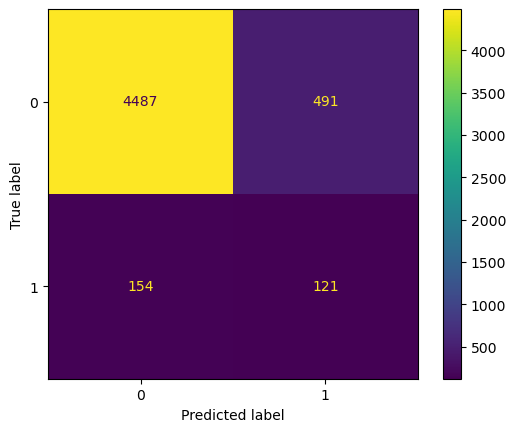

In [70]:
preds = voting_best.predict(X_test)
cm_disp = ConfusionMatrixDisplay.from_predictions(y_test, preds)

In [71]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      4978
           1       0.20      0.44      0.27       275

    accuracy                           0.88      5253
   macro avg       0.58      0.67      0.60      5253
weighted avg       0.93      0.88      0.90      5253



In [72]:
voting_best.fit(X, y)

Pipeline(steps=[('transform',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('MinMaxScaler',
                                                  MinMaxScaler(),
                                                  ['Latitude', 'Longitude',
                                                   'AddressAccuracy', 'Tavg',
                                                   'Depart', 'Heat',
                                                   'PrecipTotal', 'SeaLevel',
                                                   'ResultDir', 'AvgSpeed',
                                                   'Humidity', 'Daylight_hours',
                                                   'Month', 'Day', 'Sunrise',
                                                   'Sunset']),
                                                 ('OneHotEncoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown=...
                            random_state=RandomState(MT19937) at 0x1F697F7B040)),
                ('clf',
                 VotingClassifier(estimators=[('HistGradientBoost',
                                               HistGradientBoostingClassifier(l2_regularization=0.1,
                                                                              learning_rate=0.01,
                                                                              max_iter=300,
                                                                              random_state=RandomState(MT19937) at 0x1F697F7BC40)),
                                              ('AdaBoost',
                                               AdaBoostClassifier(n_estimators=150,
                                                                  random_state=RandomState(MT19937) at 0x1F697F7B640))],
                                  voting='soft'))])

In [73]:
df_test = pd.read_csv('../assets/df_merge_test.csv', parse_dates=['Date', 'Sunrise_1', 'Sunset_1'])

In [74]:
df_test = create_dt_features(df_test)

In [75]:
results = voting_best.predict(df_test[X.columns])

# results = ada_best.predict(df_test[X.columns])

In [76]:
def create_predictions(predictions, filename):
    if not os.path.isdir('../output'):
        os.mkdir('../output')
    
    if not os.path.isfile(f'../output/{filename}.csv'):
        results_df = pd.DataFrame(predictions)
        results_df.insert(0, column='id', value=range(1,116294))
        results_df.to_csv(f"../output/{filename}.csv", header=["Id", "WnvPresent"], index=False)
    else:
        raise NameError(f'{filename}.csv already exists!')

In [77]:
output_filename = 'predictions_11'

create_predictions(results, output_filename)

In [78]:
table_model_results().to_csv(f'../output/params_{output_filename}.csv', index=False)